# Лабораторная работа №3.
## Клименко Виталий Б01-203
### Лабораторная работа 3 Линейная КУ 

Здесь без вариативности, просто сделать, НО обычная прогонка тут не поможет, т.к. условие на границе периодическое - нужно реализовать модификацию алгоритма прогонки из XI.7.2. (Будьте внимательны при получении матрицы трехдиагональной СЛАУ)


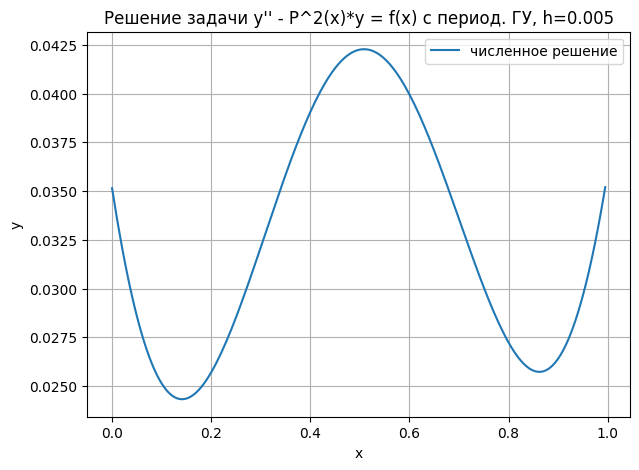

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def P2(x):
    return 10.0 + np.sin(2*np.pi*x)

def f(x):
    return np.cos(2*np.pi*x)

# решение циклической трехдиагональной системы A·y = d
# где A имеет вид (для i=0..n-1):
#   a_i на под диагональю (i.e. связь y_{i-1}),
#   b_i на диагонали,
#   c_i на над диагональю,
#   + периодическая связка: a_0 связывает y_{n-1} и y_0,
#                            c_{n-1} связывает y_{n-1} и y_0.

def solve_cyclic_tridiag(a, b, c, d):
    """
    a, b, c, d -- numpy-массивы длины n
    решение системы:
      b0*y0 + c0*y1 + a0*yn-1 = d0
      a1*y0 + b1*y1 + c1*y2   = d1
      ...
      an-1*yn-2 + bn-1*yn-1 + cn-1*y0 = dn-1
    """
    n = len(b)

    # 1) сформируем массивы для "обычной" прогонки (где предполагаем c_{n-1}=0, a_0=0)
    #    то есть убираем периодические связи, чтобы получить базовую СЛАУ T y = d
    #    T будет строго трехдиагональная без "склейки" 0..n-1
    #    (затем учтем разницу методом шермана-моррисона)
    bb = b.copy()
    cc = c.copy()
    aa = a.copy()
    dd = d.copy()

    # "убираем" периодические элементы
    cc[-1] = 0.0
    aa[0] = 0.0

    # вспомогательная функция — решение обычной трехдиагональной системы (метод томаса)
    def thomas_solve(a_, b_, c_, d_):
        n_ = len(b_)
        # прямой ход
        for i_ in range(1, n_):
            w = a_[i_] / b_[i_-1]
            b_[i_] = b_[i_] - w*c_[i_-1]
            d_[i_] = d_[i_] - w*d_[i_-1]
        # обратный ход
        x_ = np.zeros(n_)
        x_[-1] = d_[-1]/b_[-1]
        for i_ in range(n_-2, -1, -1):
            x_[i_] = (d_[i_] - c_[i_]*x_[i_+1]) / b_[i_]
        return x_

    # 2) решаем T y1 = d
    b1 = bb.copy()
    c1 = cc.copy()
    a1 = aa.copy()
    d1 = dd.copy()
    y1 = thomas_solve(a1, b1, c1, d1)

    # 3) решаем T z = r, где r = [r0, 0, 0, ..., rn-1],
    #    r0 = -a0, rn-1 = -c_{n-1}, остальные 0
    #    то есть r = [ -a0, 0, 0, ..., 0, -c_{n-1} ]
    r = np.zeros(n)
    r[0] = -a[0]
    r[-1] = -c[-1]
    b2 = bb.copy()
    c2 = cc.copy()
    a2 = aa.copy()
    d2 = r.copy()
    z = thomas_solve(a2, b2, c2, d2)

    # 4) финальное решение:
    #    y = y1 + ( (y0 - y_{n-1}) / (1 + z0 + z_{n-1}) ) * z
    #    но вместо (y0 - y_{n-1}) нужно взять (d0 - ...) формулу Шермана-Моррисона
    #    упрощенно: alpha = ( y1[0] + y1[-1] ) / (1 + z[0] + z[-1]) — (для данного знака)
    #
    # обычно формула такова:
    #   y = y1 + ( ( d0 - (b0*y1[0] + c0*y1[1] + a0*y1[n-1]) ) / ( ... ) ) * z
    # но поскольку d0 уже было учтено, можно проще использовать условие периодичности,
    #   y(0) - y(n-1) = 0  =>  (y1(0) + alpha*z(0)) - (y1(n-1)+ alpha*z(n-1))=0
    # => alpha*(z(0) - z(n-1)) = y1(n-1)-y1(0)
    # => alpha = (y1(0) - y1(n-1)) / (z(0)-z(n-1))
    # при условии z(0)-z(n-1] != 0

    denom = (z[0] - z[-1])
    if abs(denom) < 1e-14:
        print("предупреждение: (z[0]-z[n-1]) очень мало, результат может быть неверным")
    alpha = (y1[0] - y1[-1]) / denom
    y = y1 + alpha*z

    return y

def solve_periodic_diff_equation(h=0.005):
    # сетка
    N = int(1/h)  # 200 при h=0.005
    x_vals = np.linspace(0, 1-h, N)  # 0..(1-h), шаг h
    # коэффициенты в нашем разностном уравнении:
    #  A = 1/h^2, B = -2/h^2 - P^2(x), C = 1/h^2
    #  т.е. для i=0..N-1:
    #  A_i * y_{i-1} + B_i * y_i + C_i * y_{i+1} = f_i
    #  при этом y_{-1} = y_{N-1}, y_{N} = y_0 (периодическая связка)

    A = np.ones(N)*(1/h**2)   # под диагональю
    B = np.zeros(N)
    C = np.ones(N)*(1/h**2)   # над диагональю
    D = np.zeros(N)           # правая часть

    for i in range(N):
        xi = x_vals[i]
        pp = P2(xi)  # P^2(x)
        B[i] = -2/h**2 - pp
        D[i] = f(xi)  # f(x)

    #  решаем циклическую трехдиагональную систему
    y_sol = solve_cyclic_tridiag(A, B, C, D)
    return x_vals, y_sol

if __name__ == "__main__":
    # запускаем
    x, y = solve_periodic_diff_equation(h=0.005)

    plt.figure(figsize=(7,5))
    plt.plot(x, y, label='численное решение')
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Решение задачи y\'\' - P^2(x)*y = f(x) с период. ГУ, h=0.005')
    plt.legend()
    plt.show()


# Заключение

Применили разностную схему, которая формирует трёхдиагональную систему с «замыканием» концов. Обычная прогонка (метод томаса) не работает напрямую, поэтому использовали модифицированный алгоритм (cyclic thomas).  
Так же была учтена связь $$y_0=y_{N}$$ Формально матрица получается не просто трёхдиагональной, а с элементами в «углах», что нарушает классическую прогонку. Решение достигается путём двух прогонок и комбинации решений(приём Шермана–Моррисона).